$$
\LaTeX macros
\newcommand{\pba}{{p^b_a}}
\newcommand{\de}{{\dot{e}}}
\newcommand{\dde}{{\ddot{e}}}
\newcommand{\pbd}{{p^b_d}}
\newcommand{\dpba}{{\dot{p}^b_a}}
\newcommand{\ddpba}{{\ddot{p}^b_a}}
\newcommand{\dpbd}{{\dot{p}^b_d}}
\newcommand{\ddpbd}{{\ddot{p}^b_d}}
\newcommand{\pag}{{p^a_g}}
\newcommand{\pav}{{p^a_v}}
\newcommand{\dpag}{{\dot{p}^a_g}}
\newcommand{\pai}{{p^a_i}}
\newcommand{\dpai}{{\dot{p}^a_i}}
\newcommand{\pbg}{{p^b_g}}
\newcommand{\dpbg}{{\dot{p}^b_g}}
\newcommand{\ddpbg}{{\ddot{p}^b_g}}
\newcommand{\pbi}{{p^b_i}}
\newcommand{\dpbi}{{\dot{p}^b_i}}
\newcommand{\ddpbi}{{\ddot{p}^b_i}}
\newcommand{\Rba}{{R^b_a}}
\newcommand{\dRba}{{\dot{R}{}^b_a}}
\newcommand{\ddRba}{{\ddot{R}{}^b_a}}
\newcommand{\Rab}{{R^a_b}}
\newcommand{\omaa}{{\omega^a_a}}
\newcommand{\domaa}{{\dot{\omega}{}^a_a}}
\newcommand{\Somaa}{{S\left(\omega^a_a\right)}}
\newcommand{\dSomaa}{{S\left(\dot{\omega}{}^a_a\right)}}
\newcommand{\Spag}{{S\left(p^a_g\right)}}
\newcommand{\Spai}{{S\left(p^a_i\right)}}
\newcommand{\nuaa}{{\nu^a_a}}
\newcommand{\dnuaa}{{\dot{\nu}{}^a_a}}
\newcommand{\Fb}{{F^b}}
\newcommand{\Fa}{{F^a}}
\newcommand{\Fg}{{F_g}}
\newcommand{\Fv}{{F_v}}
\newcommand{\Ng}{{N_g}}
\newcommand{\Nv}{{N_v}}
\newcommand{\Fe}{{F^{ext}}}
\newcommand{\Na}{{N^a}}
\newcommand{\iM}{{M^{-1}}}
\newcommand{\BM}{\left[\begin{matrix}}
\newcommand{\EBM}{\end{matrix}\right]}
\newcommand{\gamaa}{{\gamma^a_a}}
\newcommand{\dgamaa}{{\dot{\gamma}{}^a_a}}
\newcommand{\vx}{\vec{x}}
\newcommand{\vt}{\vec{\tau}}
\newcommand{\vn}{\vec{\nu}}
\newcommand{\T}{^\top}
\newcommand{\o}[1]{{\overline{#1}}}
\newcommand{\d}[2]{{\frac{\partial #1}{\partial #2}}}
\newcommand{\xpba}{{\,}^x{\!}p^b_a}
\newcommand{\ypba}{{\,}^y{\!}p^b_a}
\newcommand{\As}{{A^{\!*}}}
$$


## Implementacja "Robust global stabilization and disturbance rejection of an underactuated nonholonomic airship"

Link do implementowanego artykułu: https://ieeexplore.ieee.org/document/4389345

# Import

In [2]:
import sympy as sp
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt # ploting results
from scipy.integrate import solve_ivp # solving differential equations
MAT = np.array

In [3]:
#definicja dekoratora log_results
import functools

def log_results(func):
    @functools.wraps(func)
    def w_dec(*args, **kwargs):
        res = func(*args, **kwargs)
        t_old = -1 if len(w_dec.t) == 0 else w_dec.t[-1]
        t_new = args[0]
        if t_new > t_old:
            w_dec.log.append(res)
            w_dec.t.append(args[0])
        else:
            f = filter(lambda x: x >= t_new, w_dec.t)
            idx = w_dec.t.index(next(f))
            w_dec.log = w_dec.log[0:idx]+[res]
            w_dec.t = w_dec.t[0:idx]+[t_new]
        return res
    w_dec.log = []
    w_dec.t = []
    return w_dec

# Definicja zmiennych

In [4]:
t = sp.symbols('t') # czas
tta = sp.symbols('\\theta', cls=sp.Function) # kąt obrotu sterowca w układzie globalnym
u = sp.symbols('u', cls=sp.Function) # prędkość wzdłużna sterowca w układzie lokalnym
v = sp.symbols('v', cls=sp.Function) # prędkość poprzeczna sterowca w układzie lokalnym
r = sp.symbols('r', cls=sp.Function) # prędkość obrotowa sterowca w układzie globalnym
x, y = sp.symbols('x y', cls=sp.Function) # położenie sterowca w układzie globalnym
F, fu, fv, fr = sp.symbols('F f_{u} f_{v} f_{r}', cls=sp.Function) # funkcje symboliczne
z1, z2, z3 = sp.symbols('z_{1} z_{2} z_{3}', cls=sp.Function) # ?
Tt, rf, alpha = sp.symbols('\\theta_{f} r_{f} \\alpha', cls=sp.Function)
tauu, taur = sp.symbols('\\tau_{u} \\tau_{r}') # sygnały sterujące kolejno: siła ciągu, siła skręcająca 
ub, vb, z1b, z2b, z3b = sp.symbols('\\bar{u} \\bar{v} \\bar{z}_{1} \\bar{z}_{2} \\bar{z}_{3}')#nowe zmienne stanu po transforma

# Współczynniki

In [5]:
Cu, Cv, Cr = sp.symbols('C_{u} C_{v} C_{r}') #współczynniki aerodynamiczne względem osi u v r
Vw = sp.symbols('V_{w}') #prędkość wiatru (w artykule jest zawsze stała)
a_ship, b_ship = sp.symbols('a_{ship} b_{ship}') #długość sterowca, szerokość sterowca
m, m3 = sp.symbols('m m_{3}') # masa strowca m=m1=m2, masa sterowca m3------------------------------------
d1, d2, d3, th3 = sp.symbols('d_{1} d_{2} d_{3} \\theta_{3}') # współczynniki tłumienia kolejno w osi u v r
d1f, d2f, d3f, th3f = sp.symbols('\\underline{d}_{1} \\underline{d}_{2} \\underline{d}_{3} \\underline{\\theta}_{3}') # dolne wartości wsp tłumienia d1, d2, d3
d1c, d2c, d3c, th3c = sp.symbols('\\bar{d}_{1} \\bar{d}_{2} \\bar{d}_{3} \\bar{\\theta}_{3}') # górne wartości współczynników tłumienia d1, d2, d3
d10, d20, d30, th30 = sp.symbols('d_{10} d_{20} d_{30} \\theta_{30}') # niepewności
Delta_1, Delta_2, Delta_3, delta_1, delta_2, delta_3 = sp.symbols('\\Delta_{1} \\Delta_{2} \\Delta_{3} \\delta_{1} \\delta_{2} \\delta_{3}')# niepewności
k1, k2, k3, a = sp.symbols('k_{1} k_{2} k_{3} a') # współczynniki wzmocnień syg ster tau_r
k_th, k_r  = sp.symbols('k_{\\theta} k_{r}') # jak wyżej
k1b, k2b, k3b, k4b, k5b = sp.symbols('\\bar{k}_{1} \\bar{k}_{2} \\bar{k}_{3} \\bar{k}_{4} \\bar{k}_{5}')#wsp wzm sterownika tau_u
th_1, th_2, th_3 = sp.symbols('\\theta_1 \\theta_2 \\theta_3') # współczynniki th z obliczone na podst wzoru 4.4
lam_1, lam_2 = sp.symbols('\lambda_1 \lambda_2') # współczynniki lam z obliczone na podst wzoru 4.4
delta_d = sp.symbols('\\Delta_{d}') # współczynnik deltad ze wzoru 4.3
th_0, r_0 = sp.symbols('th(0) r(0)')# wartości początkowe

Opis modelu kinematycznego, geometrycznego powiązania pomiędzy układem globalnym a układem lokalnym $\BM \dot{x}\\\dot{y}\\\dot{\theta}\EBM$ - rozdział II (2.4)

In [6]:
dx_ = u(t) * sp.cos(tta(t)) - v(t) * sp.sin(tta(t))
dy_ = u(t) * sp.sin(tta(t)) + v(t) * sp.cos(tta(t))
dtta_ = r(t)
kin_ = sp.Matrix([[dx_],[dy_],[dtta_]])
display(dx_,dy_,dtta_)

u(t)*cos(\theta(t)) - v(t)*sin(\theta(t))

u(t)*sin(\theta(t)) + v(t)*cos(\theta(t))

r(t)

Ciąg dalszy opisu kinematyki, $z_1$ i $z_2$ - rozdział II (2.5)

In [7]:
z1_ = x(t) * sp.cos(tta(t)) + y(t) * sp.sin(tta(t))
z2_ = -x(t) * sp.sin(tta(t)) + y(t) * sp.cos(tta(t))
#wyświetlanie implementowanych wzorów
display(z1_,z2_)

x(t)*cos(\theta(t)) + y(t)*sin(\theta(t))

-x(t)*sin(\theta(t)) + y(t)*cos(\theta(t))

Równanie stanu uzyskane przez połączenie kinematyki i dynamiki sterowca - rozdział II (2.6)

In [8]:
# układ Sigma1:
# macierz stanu
A1 = sp.Matrix([[-d1,r(t),0,0],[-r(t),-d2,0,0],[1,0,0,r(t)],[0,1,-r(t),0]])  
q = sp.Matrix([[u(t),v(t),z1(t),z2(t)]]).T # wektor stanu
b1 = sp.Matrix([[1/m,0,0,0]]).T # macierz sterowania
# wektor sił zakłóceń - wiatru
f1 = sp.Matrix([[fu(tta(t))/m,fv(tta(t))/m,0,0]]).T 
s_ = A1@q+b1*tauu+f1
#wyświetlanie implementowanych wzorów
#display(s_)
display(A1,q,b1,f1)

Matrix([
[-d_{1},   r(t),     0,    0],
[ -r(t), -d_{2},     0,    0],
[     1,      0,     0, r(t)],
[     0,      1, -r(t),    0]])

Matrix([
[    u(t)],
[    v(t)],
[z_{1}(t)],
[z_{2}(t)]])

Matrix([
[1/m],
[  0],
[  0],
[  0]])

Matrix([
[f_{u}(\theta(t))/m],
[f_{v}(\theta(t))/m],
[                 0],
[                 0]])

In [9]:
# układ Sigma2:                                    #ten układ umieścić w funkcji symulacji
dr_ = -d3 * r(t) + (1/m3) * (taur + fr(tta(t))) 
dth_ = r(t)
display(dr_,dth_)

-d_{3}*r(t) + (\tau_{r} + f_{r}(\theta(t)))/m_{3}

r(t)

Dynamika sterowca

In [10]:
dyn_ = sp.Matrix([[s_.row(0)],[s_.row(1)],[dr_]])
dyn_

Matrix([
[\tau_{u}/m - d_{1}*u(t) + r(t)*v(t) + f_{u}(\theta(t))/m],
[            -d_{2}*v(t) - r(t)*u(t) + f_{v}(\theta(t))/m],
[       -d_{3}*r(t) + (\tau_{r} + f_{r}(\theta(t)))/m_{3}]])

Sygnał sterujący $\tau_r$ dla podsystemu $\Sigma_2$ oraz współczynniki $k_r$ i $k_{\theta}$ - rozdział IV (4.1)

In [11]:
taur_ = m3 * (-k_r * r(t) - k_th * tta(t) + a * sp.exp(-k3 * t) - fr(tta(t))) 
kr = k1 + k2 - d3c
ktta = k1*k2
podstaw={k_r:kr,k_th:ktta}
display(taur_,kr,ktta)

m_{3}*(a*exp(-k_{3}*t) - k_{\theta}*\theta(t) - k_{r}*r(t) - f_{r}(\theta(t)))

-\bar{d}_{3} + k_{1} + k_{2}

k_{1}*k_{2}

Odpowiedź kąta $\theta(t)$ i prędkości kątowej $r(t)$ jest dana - rozdział IV (4.3)

In [12]:
Tt_ = th_1*sp.exp(-lam_1*t) + th_2*sp.exp(-lam_2*t) + th_3*sp.exp(-k3*t) # th(t)
R_ = -th_1*lam_1*sp.exp(-lam_1*t) - th_2*lam_2*sp.exp(-lam_2*t) - th_3*k3*sp.exp(-k3*t) # r(t)
podstaw.update({rf(t):R_}) 
display(Tt_,R_)

\theta_1*exp(-\lambda_1*t) + \theta_2*exp(-\lambda_2*t) + \theta_3*exp(-k_{3}*t)

-\lambda_1*\theta_1*exp(-\lambda_1*t) - \lambda_2*\theta_2*exp(-\lambda_2*t) - \theta_3*k_{3}*exp(-k_{3}*t)

Funkcja $\alpha(t)$ - rozdział IV (4.14)

In [13]:
Alp_ = -(th_1*lam_1*sp.exp(-(lam_1-k3)*t)+th_2*lam_2*sp.exp(-(lam_2-k3)*t)) #funkcja alpha(t)
podstaw.update({alpha(t):Alp_})
display(Alp_)

-\lambda_1*\theta_1*exp(t*(-\lambda_1 + k_{3})) - \lambda_2*\theta_2*exp(t*(-\lambda_2 + k_{3}))

Implementacja współczynników $\theta_1$, $\theta_2$ oraz $\theta_3$ - rozdział IV (4.4)

In [14]:
th_1_ = ((lam_2*th_0 + r_0)/(lam_2 - lam_1)) + a/((lam_2 - lam_1)*(k3 - lam_1))
th_2_ = ((k1*th_0 + r_0)/(lam_1 - lam_2)) + a/((lam_1 - lam_2)*(k3 - lam_2))
th_3_ = a/((lam_1 - k3)*(lam_2 - k3))
podstaw.update({th_1:th_1_,th_2:th_2_,th_3:th_3_})
#wyświetlanie implementowanych wzorów
display(th_1_,th_2_,th_3_)  

a/((-\lambda_1 + \lambda_2)*(-\lambda_1 + k_{3})) + (\lambda_2*th(0) + r(0))/(-\lambda_1 + \lambda_2)

a/((\lambda_1 - \lambda_2)*(-\lambda_2 + k_{3})) + (k_{1}*th(0) + r(0))/(\lambda_1 - \lambda_2)

a/((\lambda_1 - k_{3})*(\lambda_2 - k_{3}))

Implementacja współczynników $\lambda_1$ i $\lambda_2$ - rozdział IV (4.4)

In [15]:
lam_1_ = ((delta_d + k1 + k2) + sp.sqrt(delta_d**2 + 2*delta_d*(k1 + k2) + (k1 - k2)**2))/2#
lam_2_ = ((delta_d + k1 + k2) - sp.sqrt(delta_d**2 + 2*delta_d*(k1 + k2) + (k1 - k2)**2))/2#
delta_d_ = d3 - d3f#
podstaw.update({lam_1:lam_1_,lam_2:lam_2_,delta_d:delta_d_})
#wyświetlanie implementowanych wzorów
display(lam_1_,lam_2_,delta_d_)

\Delta_{d}/2 + k_{1}/2 + k_{2}/2 + sqrt(\Delta_{d}**2 + 2*\Delta_{d}*(k_{1} + k_{2}) + (k_{1} - k_{2})**2)/2

\Delta_{d}/2 + k_{1}/2 + k_{2}/2 - sqrt(\Delta_{d}**2 + 2*\Delta_{d}*(k_{1} + k_{2}) + (k_{1} - k_{2})**2)/2

-\underline{d}_{3} + d_{3}

Implementacja systemu $\Sigma_{1e}$ - rozdział IV (4.7)

In [16]:
A2 = sp.Matrix([[-d1,rf(t),0,0,0],[-rf(t),-d2,0,0,0],[1,0,0,rf(t),0],[0,1,-rf(t),0,0],[0,0,1,0,0]])# macierz stanu
b2 = sp.Matrix([[1/m,0,0,0,0]]).T # macierz sterowania
ff = sp.Matrix([[fu(tta(t))/m,-fv(tta(t))/m,0,0,0]]).T # wektor zakłóceń - wiatru
q2 = sp.Matrix([[u(t),v(t),z1(t),z2(t),z3(t)]]).T # wektor stanu
display(A2,b2,ff,q2)
#display(dX1_sym)

Matrix([
[   -d_{1}, r_{f}(t),         0,        0, 0],
[-r_{f}(t),   -d_{2},         0,        0, 0],
[        1,        0,         0, r_{f}(t), 0],
[        0,        1, -r_{f}(t),        0, 0],
[        0,        0,         1,        0, 0]])

Matrix([
[1/m],
[  0],
[  0],
[  0],
[  0]])

Matrix([
[ f_{u}(\theta(t))/m],
[-f_{v}(\theta(t))/m],
[                  0],
[                  0],
[                  0]])

Matrix([
[    u(t)],
[    v(t)],
[z_{1}(t)],
[z_{2}(t)],
[z_{3}(t)]])

Nowy wektor stanu $\bar{x}$ - rozdział IV (4.10)

In [17]:
ub = u(t)
vb = v(t) * sp.exp(-k3 * t)
z1b = z1(t)
z2b = z2(t) * sp.exp(-k3 * t)
z3b = z3(t)
Xb = sp.Matrix([[ub,vb,z1b,z2b,z3b]]).T
#wyświetlanie implementowanych wzorów
display(Xb)

Matrix([
[                  u(t)],
[    v(t)*exp(-k_{3}*t)],
[              z_{1}(t)],
[z_{2}(t)*exp(-k_{3}*t)],
[              z_{3}(t)]])

Współczynniki $d_1$, $d_2$, $\theta_3$ - rozdział IV (4.11)

In [18]:
d1_ = d10 + Delta_1#
d2_ = d20 + Delta_2#
th3_ = th30 + Delta_3#
podstaw.update({d1:d1_,d2:d2_,th3:th3_})
#wyświetlanie implementowanych wzorów
display(d1_,d2_,th3_)

\Delta_{1} + d_{10}

\Delta_{2} + d_{20}

\Delta_{3} + \theta_{30}

Rozszerzony system $\Sigma_{1e}$ bez zakłócenia $f(t)$ - rozdział IV (4.13) i (4.14)

In [19]:
#macierze o stałych współczynnikach
A10 = sp.Matrix([[-d10,0,0,0,0],[th30*k3,-(d20-k3),0,0,0],[1,0,0,0,0],[0,1,th30*k3,k3,0],[0,0,1,0,0]])#
D = sp.Matrix([[1,0,0,0],[0,1,1,0],[0,0,0,0],[0,0,0,1],[0,0,0,0]])#
E = sp.Matrix([[-delta_1,0,0,0,0],[0,-delta_2,0,0,0],[k3*delta_3,0,0,0,0],[0,0,k3*delta_3,0,0]])#
DELTA = sp.Matrix.diag([Delta_1/delta_1,Delta_2/delta_2,Delta_3/delta_3,Delta_3/delta_3])#
#macierz o zmiennych współczynnikach
A22 = sp.Matrix([[0,rf(t)*sp.exp(-k3*t),0,0,0],[alpha(t),0,0,0,0],[0,0,0,rf(t)*sp.exp(-k3*t),0],[0,0,alpha(t),0,0],[0,0,0,0,0]])
#wyświetlanie implementowanych wzorów
display(A22)
display(A10,D,E,DELTA)

Matrix([
[        0, r_{f}(t)*exp(-k_{3}*t),         0,                      0, 0],
[\alpha(t),                      0,         0,                      0, 0],
[        0,                      0,         0, r_{f}(t)*exp(-k_{3}*t), 0],
[        0,                      0, \alpha(t),                      0, 0],
[        0,                      0,         0,                      0, 0]])

Matrix([
[          -d_{10},               0,                 0,     0, 0],
[\theta_{30}*k_{3}, -d_{20} + k_{3},                 0,     0, 0],
[                1,               0,                 0,     0, 0],
[                0,               1, \theta_{30}*k_{3}, k_{3}, 0],
[                0,               0,                 1,     0, 0]])

Matrix([
[1, 0, 0, 0],
[0, 1, 1, 0],
[0, 0, 0, 0],
[0, 0, 0, 1],
[0, 0, 0, 0]])

Matrix([
[     -\delta_{1},           0,                0, 0, 0],
[               0, -\delta_{2},                0, 0, 0],
[\delta_{3}*k_{3},           0,                0, 0, 0],
[               0,           0, \delta_{3}*k_{3}, 0, 0]])

Matrix([
[\Delta_{1}/\delta_{1},                     0,                     0,                     0],
[                    0, \Delta_{2}/\delta_{2},                     0,                     0],
[                    0,                     0, \Delta_{3}/\delta_{3},                     0],
[                    0,                     0,                     0, \Delta_{3}/\delta_{3}]])

Wzory potrzebne do obliczenia wspóółczynników $d_1$, $d_2$, $\theta_3$ - rozdział IV (4.12)

In [20]:
delta_3_ = (th3c - th3f)/2 #
th30_ = (th3c + th3f)/2 #
podstaw.update({delta_3:delta_3_,th30:th30_})
display(delta_3_,th30_)

\bar{\theta}_{3}/2 - \underline{\theta}_{3}/2

\bar{\theta}_{3}/2 + \underline{\theta}_{3}/2

In [21]:
th3f_ = a/((k3 - k1)*(k3 - k2))#
th3c_ = a/(k3**2 - (d3c + k_r)*k3 + k1*k2)#
d10_ = (d1c + d1f)/2#
d20_ = (d2c + d2f)/2#
d30_ = (d3c + d3f)/2#
delta_1_ = (d1c - d1f)/2#
delta_2_ = (d2c - d2f)/2#
podstaw.update({delta_1:delta_1_,delta_2:delta_2_,th3f:th3f_,th3c:th3c_,d10:d10_,d20:d20_,d30:d30_})
#wyświetlanie implementowanych wzorów
display(th3f_,th3c_,d10_,d20_,d30_,delta_1_,delta_2_)

a/((-k_{1} + k_{3})*(-k_{2} + k_{3}))

a/(k_{1}*k_{2} + k_{3}**2 - k_{3}*(\bar{d}_{3} + k_{r}))

\bar{d}_{1}/2 + \underline{d}_{1}/2

\bar{d}_{2}/2 + \underline{d}_{2}/2

\bar{d}_{3}/2 + \underline{d}_{3}/2

\bar{d}_{1}/2 - \underline{d}_{1}/2

\bar{d}_{2}/2 - \underline{d}_{2}/2

Sygnał sterujący $\tau_u$ - rozdział IV (4.21)

In [22]:
tauu_ = -(k1b*u(t)+k2b*v(t)*sp.exp(-k3*t)+k3b*z1(t)+k4b*z2(t)*sp.exp(-k3*t)+k5b*z3(t))
#wyświetlanie implementowanych wzorów
display(tauu_)

-\bar{k}_{1}*u(t) - \bar{k}_{2}*v(t)*exp(-k_{3}*t) - \bar{k}_{3}*z_{1}(t) - \bar{k}_{4}*z_{2}(t)*exp(-k_{3}*t) - \bar{k}_{5}*z_{3}(t)

Wektor zakłóceń $\bar{f}(t)$ - rozdział IV (4.26)

In [23]:
#wektor zakłóceń
fb = sp.Matrix([[Cu*Vw**2*F(tta(t))*sp.cos(tta(t))/m,-Cv*Vw**2*sp.exp(-k3*t)*F(tta(t))*sp.sin(tta(t))/m,0,0,0]]).T 
display(fb)  

Matrix([
[               C_{u}*V_{w}**2*F(\theta(t))*cos(\theta(t))/m],
[-C_{v}*V_{w}**2*F(\theta(t))*exp(-k_{3}*t)*sin(\theta(t))/m],
[                                                          0],
[                                                          0],
[                                                          0]])

Definicja funkcji $f_u$, $f_v$, $f_r$ oraz $F(\theta)$ - rozdział II (2.2)

In [24]:
fu_ = Cu * Vw**2 * F(tta(t)) * sp.cos(tta(t))
fv_ = Cv * Vw**2 * F(tta(t)) * sp.sin(tta(t))
fr_ = Cr * Vw**2 * F(tta(t)) * sp.cos(2 * tta(t))
podstaw.update({fu(tta(t)):fu_,fv(tta(t)):fv_,fr(tta(t)):fr_})
display(fu_,fv_,fr_) 

C_{u}*V_{w}**2*F(\theta(t))*cos(\theta(t))

C_{v}*V_{w}**2*F(\theta(t))*sin(\theta(t))

C_{r}*V_{w}**2*F(\theta(t))*cos(2*\theta(t))

In [25]:
F_ = sp.sqrt(a_ship**2 * sp.sin(tta(t))**2 + b_ship**2 * sp.cos(tta(t))**2)
podstaw.update({F(tta(t)):F_})
display(F_)

sqrt(a_{ship}**2*sin(\theta(t))**2 + b_{ship}**2*cos(\theta(t))**2)

Wzory na $\Delta_i$ - warunek konieczny: $\Delta_i \leq \delta_i$ - rozdział (4.11)

In [26]:
Delta_1_ = delta_1
Delta_2_ = delta_2
Delta_3_ = delta_3
podstaw.update({Delta_1:Delta_1_,Delta_2:Delta_2_,Delta_3:Delta_3_})
#display(Delta_1_,Delta_2_,Delta_3_)

Wektor wzmocnień sterownika $\bar{k}$ - rozdział IV (4.21)

In [27]:
Kb = sp.Matrix([[k1b,k2b,k3b,k4b,k5b]])
display(Kb)

Matrix([[\bar{k}_{1}, \bar{k}_{2}, \bar{k}_{3}, \bar{k}_{4}, \bar{k}_{5}]])

Definicja systemu $\Sigma_{1e}$ - rozdział IV wzór (4.25)

In [28]:
sys_ = (A10 - b2@Kb + D@DELTA@E) @ Xb + fb

## ----------------------------------------------------------------------------------------------------------------------------------

# Podstawienie wartości do zmiennych symbolicznych

In [29]:
params = {a_ship:1.2,b_ship:0.5} #Podstawienie wymiarów sterowca
params.update({Cu:0.02,Cv:0.02,Cr:0.02,Vw:0.1}) #Podstawienie wartości współczynników aerodynamicznych i prędkości wiatru
params.update({m:0.072, m3:0.018})#Podstawienie wartości masy strowca m=m1=m2, masa sterowca m3
params.update({d1f:0.008, d2f:0.029, d3f:0.035})#Podstawienie dolnych wartości współczynników tłumienia
params.update({d1c:0.01, d2c:0.057, d3c:0.05})#Podstawienie górnych wartości współczynników tłumienia
params.update({k1:0.52, k2:0.5, k3:0.35, a:0.15})#Podstawienie wartości wzmocnień kontrolera tau_r
params.update({k1b:1.6, k2b:0.13, k3b:1.0, k4b:0.16, k5b:0.0032})#Podstawienie wartości
params.update({th_0:1,r_0:0})#Wartości początkowe kąta, prędkości kątowej
params.update({d3:0.05})

# Definicja funkcji numerycznych

In [30]:
tauu_num = log_results(sp.lambdify((t,u(t),v(t),z1(t),z2(t),z3(t)),tauu_.subs(params)))
taur_num = log_results(sp.lambdify((t,r(t),tta(t)),(((taur_.subs(podstaw)).subs(podstaw)).subs(podstaw)).subs(params)))
kin_num = sp.lambdify((u(t),v(t),r(t),tta(t)),kin_)
dyn_num = sp.lambdify((u(t),v(t),r(t),tta(t),tauu,taur),dyn_.subs(podstaw).subs(podstaw).subs(params))
z1_num = sp.lambdify((x(t),y(t),tta(t)),z1_.subs(params))
z2_num = sp.lambdify((x(t),y(t),tta(t)),z2_.subs(params))
sys1e_num = sp.lambdify((u(t),v(t),z1(t),z2(t),z3(t),tta(t),t),sys_.subs(podstaw).subs(podstaw).subs(params))
sys1_num = sp.lambdify((u(t),v(t),z1(t),z2(t),r(t),tta(t),tauu),s_.subs(podstaw).subs(podstaw).subs(params))

## Definicja funkcji symulacji

In [31]:
def Blimp(t_, x0_array):
    x0 = MAT([x0_array]).T
    xi = MAT(x0[0][0])
    yi = MAT(x0[1][0])
    ttai = MAT(x0[2][0])
    ui = MAT(x0[3][0])
    vi = MAT(x0[4][0])
    ri = MAT(x0[5][0])#
    
    z1i = z1_num(xi,yi,ttai)
    z2i = z2_num(xi,yi,ttai)  
    z3i = 0
    
    uu = tauu_num(t_,ui,vi,z1i,z2i,z3i)
    ur = taur_num(t_,ri,ttai)#
            
    d1 = kin_num(ui,vi,ri,ttai)#
    d2 = dyn_num(ui,vi,ri,ttai,uu,ur)#
    # Zbieranie wyników
    dxi = np.concatenate((d1,d2))
    return np.ndarray.tolist(dxi.T[0])

# Przygotowanie symulacji

In [37]:
xi0_array = [0,0.8,65*np.pi/180,0,0,0]#wartości początkowe zmiennych
time_sym = 5 # Czas trwania symulacji
sim = solve_ivp(Blimp, [0, time_sym], xi0_array, method='RK45')
t = sim.t
xp, yp, ttap, u, v, r = sim.y # return xi   

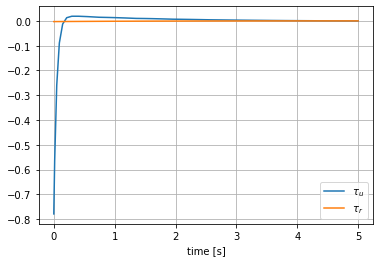

In [40]:
# wyciągnięcie pomiarów, dla momentów czasu w wektorze t
tauu = [tauu_num.log[tauu_num.t.index(time)] for time in t]
taur = [taur_num.log[taur_num.t.index(time)] for time in t]
plt.figure()
plt.plot(t,tauu, label='$\\tau_u$')
plt.plot(t,taur, label='$\\tau_r$')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.grid(True)


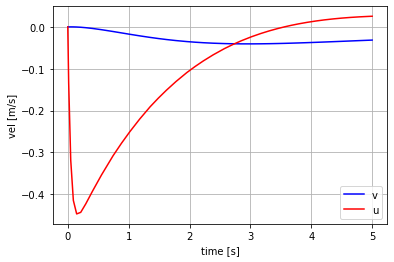

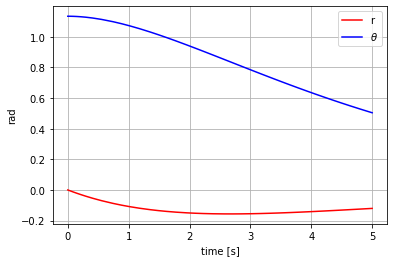

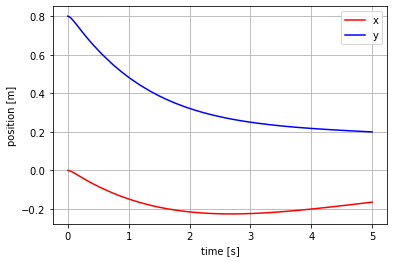

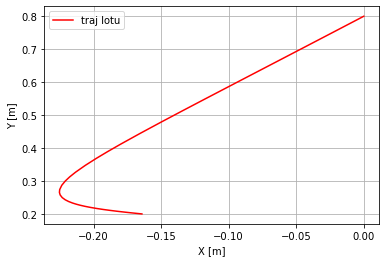

In [39]:
#wykres prędkości w lokalnym układzie sterowca >
plt.figure()
plt.plot(t, v, 'b', label='v')
plt.plot(t, u, 'r', label='u')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('vel [m/s]')
plt.grid(True)
plt.show()
#wykres wykres prędkości kątowej r i kąta theta >
plt.figure()
plt.plot(t, r, 'r', label='r')
plt.plot(t, ttap, 'b', label='$\\theta$')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('rad')
plt.grid(True)
plt.show()

#wykres wykres x i y w funkcji czasu >
plt.figure()
plt.plot(t, xp, 'r', label='x')
plt.plot(t, yp, 'b', label='y')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('position [m]')
plt.grid(True)
plt.show()

#wykres położenia na płaszczyźnie XY >
plt.figure()
plt.plot(xp,yp, 'r', label='traj lotu')
plt.legend(loc='best')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True)
plt.show()